<a href="https://colab.research.google.com/github/veljkolazic17/PRS/blob/main/PRS1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

In [7]:
K = [2,3,4,5]

In [27]:
def calculate_lambda(P : np.array) -> np.array:
  # Calculate P transposed
  PT = P.transpose()
  # Calculate Inverse matrix
  I = np.identity(P.shape[0])
  # Calculate A
  A = np.zeros(P.shape[0])
  A[0] = 1

  # Calculate lambda vector
  L = np.matmul(np.linalg.inv(np.subtract(I, PT)), A)
  return L

K = 2 : Critical resource is user disk 1
K = 3 : Critical resource is processor
K = 4 : Critical resource is processor
K = 5 : Critical resource is processor


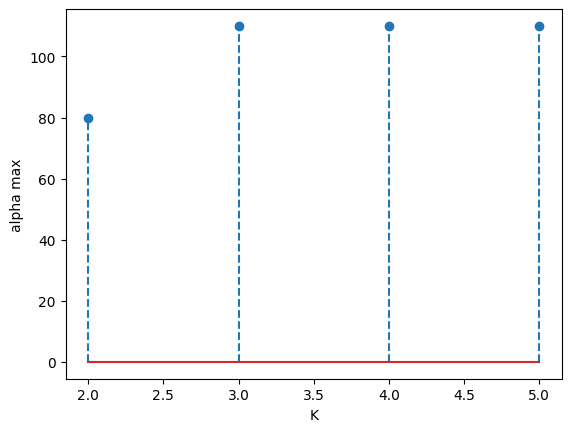

In [46]:
# Define S vector without K disks
S = np.array([0.00625, 0.01, 0.015, 0.015])

# Write to file L/A
P = np.array([[0.2, 0.15, 0.1, 0.05], 
                [0.3,  0.2,   0,    0],
                [0.3,    0, 0.2,    0],
                [0.3,    0,   0,  0.2]])

f = open('protoci_analiticki', 'w+')

a_max_arr = []

for k in K:
  # Extend P matrix with probabilities of user disks
  P_prim = P
  S_prim = S

  P_prim = np.append(P, np.full([P.shape[0], k], 0.5/k) , axis = 1)
  P_prim = np.r_[P_prim, np.zeros([k, k + P_prim.shape[0]])]
  # Write to a file
  LRes = calculate_lambda(P_prim)
  
  S_prim = np.append(S, np.full([k], 0.025))
  
  U_prim = np.multiply(LRes, S_prim)

  index = np.argmax(U_prim)
  if(index == 0):
    print("K = %d : Critical resource is processor" % k)
  elif index < 4:
    print("K = %d : Critical resource is system disk %d" % (k, index))
  else:
    print("K = %d : Critical resource is user disk %d" % (k, index - 3))



  a_max = (1/S_prim[index])/LRes[index]
  a_max_arr.append(a_max)

  f.write('K = ' + str(k) + '-'*64 + '\n' + np.array2string(LRes) + '\n')

f.close()

plt.stem(K, a_max_arr, linefmt='--')
plt.xlabel("K")
plt.ylabel("alpha max")

plt.show()
